In [1]:
import os
from pathlib import Path

from huggingface_hub import login
import wandb


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import (
    AutoModel,
    AutoImageProcessor,
    AutoConfig,
    Trainer,
    TrainingArguments,
    PreTrainedModel
)
from transformers import DINOv3ViTConfig, DINOv3ViTModel


from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score


In [2]:
#huggingface login
login()

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: saadiq-mohiuddin (saadiq-mohiuddin-developmentseed) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [37]:
image_dir = Path("data/place_pulse/images")
dinov3_model_type = "facebook/dinov3-vitb16-pretrain-lvd1689m"

In [104]:
df = pd.read_csv('data/safety_na_similarity.csv')
df.head()

choice                      left                     right study_question  \
0   left  513d9c83fdc9f03587007d7a  5185d46bfdc9f03fd50013d5          safer   
1  right  51413ae5fdc9f04926005812  5185d46bfdc9f03fd50013d5          safer   
2  right  513d7eecfdc9f035870074e6  5185d46bfdc9f03fd50013d5          safer   
3  right  513cc9f6fdc9f03587001ca0  513cbed8fdc9f035870011fe          safer   
4  right  50f607e0beb2fed6f800037d  50f6086ebeb2fed6f800048d          safer   

   choice_map             left_place_id            right_place_id  \
0         1.0  50e70a8cd7c3df413b000c72  50f38816fdc9f065f0000364   
1         0.0  50e7583bd7c3df413b0019b0  50f38816fdc9f065f0000364   
2         0.0  50e70a8cd7c3df413b000c72  50f38816fdc9f065f0000364   
3         0.0  50e755bad7c3df413b0017f3  50e5f30fd7c3df413b000303   
4         0.0  50f38ba1fdc9f065f0000646  50f38ba1fdc9f065f0000646   

   cosine_distance  
0         0.216851  
1         0.219624  
2         0.155212  
3         0.130798  
4         0.228235

In [105]:
df = df[df['choice_map'] != 0.5]
df= df[df['cosine_distance'] > 0.25] #Remove image pairs that are similar
df

choice                      left                     right  \
6       left  513d6e5efdc9f035870052cd  513d7ad7fdc9f0358700697d   
11      left  513cbd80fdc9f035870010b8  513cb84cfdc9f03587000be1   
15      left  50f433dafdc9f065f00027d3  513cb84cfdc9f03587000be1   
20      left  50f5e8cafdc9f065f00074ca  513cc1d6fdc9f035870014f1   
39      left  513d6c54fdc9f03587004f40  513cc034fdc9f0358700135b   
...      ...                       ...                       ...   
39896  right  51422748fdc9f04926008644  513cb634fdc9f03587000a02   
39897   left  513cb790fdc9f03587000b3b  513d9c8efdc9f03587007da0   
39911  right  50f433c2fdc9f065f000262a  5141463bfdc9f0492600677b   
39917   left  50f43480fdc9f065f00028d7  513d78d7fdc9f035870062db   
39918  right  513d6b1ffdc9f03587004c46  513d78d7fdc9f035870062db   

      study_question  choice_map             left_place_id  \
6              safer         1.0  50e5f69ed7c3df413b000377   
11             safer         1.0  50e5f30fd7c3df413b000303   
15             safer         1.0  50f3996efdc9f065f0000e1b   
20             safer         1.0  50f38f8afdc9f065f00008e6   
39             safer         1.0  50e5f69ed7c3df413b000377   
...              ...         ...                       ...   
39896          safer         0.0  50f38aaefdc9f065f0000562   
39897          safer         1.0  50e755bad7c3df413b0017f3   
39911          safer         0.0  50f3996efdc9f065f0000e1b   
39917          safer         1.0  50f3996efdc9f065f0000e1b   
39918          safer         0.0  50e5f168d7c3df413b000279   

                 right_place_id  cosine_distance  
6      50e734e9d7c3df413b000ebf         0.254197  
11     50e5f30fd7c3df413b000303         0.299475  
15     50e5f30fd7c3df413b000303         0.291855  
20     50e5f30fd7c3df413b000303         0.289930  
39     50e755bad7c3df413b0017f3         0.304012  
...                         ...              ...  
39896  50e755bad7c3df413b0017f3         0.267671  
39897  50e734e9d7c3df413b000ebf         0.304478  
39911  50f386b1fdc9f065f00002c8         0.310417  
39917  50e734e9d7c3df413b000ebf         0.254109  
39918  50e734e9d7c3df413b000ebf         0.304029  

[9466 rows x 8 columns]

In [119]:
X = df[["left", "right"]].values.tolist()
y = df["choice_map"].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [120]:
print(f"train:{len(X_train)}, test: {len(X_test)}")

train:8519, test: 947


In [121]:
class PlacePulseDataset(Dataset):
    def __init__(self, img_dir, choice, imgs, processor):
        self.img_dir = img_dir
        self.choice = choice
        self.imgs = imgs
        self.processor = processor

        # Prebuild index of all images in directory
        all_imgs = os.listdir(self.img_dir)
        self.id2path = {i.split("_")[2]:i for i in all_imgs}

    def __len__(self):
        return len(self.choice)

    def __getitem__(self, idx):
        left_id, right_id = self.imgs[idx]

        # Look up paths directly instead of globbing every time
        img_path_left = f"{self.img_dir}/{self.id2path[left_id]}"
        img_path_right = f"{self.img_dir}/{self.id2path[right_id]}"

        # Load + preprocess
        image_left = Image.open(img_path_left)
        image_right = Image.open(img_path_right)

        left_inputs = self.processor(image_left, return_tensors="pt")["pixel_values"][0]
        right_inputs = self.processor(image_right, return_tensors="pt")["pixel_values"][0]

        return left_inputs, right_inputs, torch.as_tensor(self.choice[idx], dtype=torch.float)


In [122]:
def collate_fn(inputs):
    batch = dict()
    batch["left_pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["right_pixel_values"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[2] for i in inputs], dim=0)
    return batch

In [123]:
processor = AutoImageProcessor.from_pretrained(dinov3_model_type)

train_dataset = PlacePulseDataset(
    image_dir,
    y_train,
    X_train,
    processor
)

val_dataset = PlacePulseDataset(
    image_dir,
    y_test,
    X_test,
    processor
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [124]:
class DinoV3Ranker(PreTrainedModel):
  config_class = DINOv3ViTConfig()
  base_model_prefix = "backbone"
  def __init__(self, config):
    super().__init__(config)

    self.backbone = DINOv3ViTModel(config)
    for param in self.backbone.parameters():
      param.requires_grad = False

    hidden_size = self.backbone.config.hidden_size
    self.classifier = nn.Linear(hidden_size, 1) #Linear probe

  def forward(self, pixel_values):
      outputs = self.backbone(pixel_values=pixel_values, return_dict=True)
      cls = outputs.last_hidden_state[:, 0, :]  # cls embedding
      score = self.classifier(cls).squeeze(1) # cls embeddings
      return score


config = AutoConfig.from_pretrained(dinov3_model_type)
model = DinoV3Ranker(config).from_pretrained(dinov3_model_type)

Some weights of DinoV3Ranker were not initialized from the model checkpoint at facebook/dinov3-vitb16-pretrain-lvd1689m and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [125]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    ) 

In [126]:
print_trainable_parameters(model)

trainable params: 769 || all params: 85661185 || trainable%: 0.00


In [127]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    r_i, r_j = preds[:, 0], preds[:, 1]
    scores = r_i - r_j  

    map_score = average_precision_score(labels, scores)
    auc_score = roc_auc_score(labels, scores)

    return {"MAP": map_score, "AUC": auc_score}


In [115]:
class PairwiseTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_accepts_loss_kwargs = False

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        left_pixel_values = inputs["left_pixel_values"]
        right_pixel_values = inputs["right_pixel_values"]
        labels = inputs["labels"].float()  

        r_i = model(left_pixel_values)
        r_j = model(right_pixel_values)

        # RankNet probability that r_i > r_j
        p_ij = torch.sigmoid(r_i - r_j)

        # Binary cross-entropy loss
        loss = F.binary_cross_entropy(p_ij, labels)

        outputs = torch.stack([r_i, r_j], dim=1)  # for metrics
        return (loss, outputs) if return_outputs else loss

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        with torch.no_grad():
            left_pixel_values = inputs["left_pixel_values"]
            right_pixel_values = inputs["right_pixel_values"]
            labels = inputs["labels"].float()

            r_i = model(left_pixel_values)
            r_j = model(right_pixel_values)

            p_ij = torch.sigmoid(r_i - r_j)
            loss = None
            if not prediction_loss_only:
                loss = F.binary_cross_entropy(p_ij, labels)

            preds = torch.stack([r_i, r_j], dim=1)
            return (loss, preds, labels)

In [128]:
training_args = TrainingArguments(
    output_dir="./outputs",
    per_device_train_batch_size=256,
    num_train_epochs=10,
    learning_rate=1e-4,
    weight_decay=1e-5,
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="steps",
    eval_steps=25,
    report_to="wandb",
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
)

trainer = PairwiseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


TrainOutput(global_step=340, training_loss=0.6095270044663373, metrics={'train_runtime': 919.8466, 'train_samples_per_second': 92.613, 'train_steps_per_second': 0.37, 'total_flos': 0.0, 'train_loss': 0.6095270044663373, 'epoch': 10.0})

In [129]:
trainer.save_model("final_model/9000_0_77AUC")

In [130]:
model_infer = DinoV3Ranker.from_pretrained("final_model/9000_0_77AUC")

In [141]:
X_test = np.array(X_test)
idxs = np.random.choice(X_test.shape[0], 20)
sample = X_test[idxs]

img_ids = [i[1] for i in sample ]

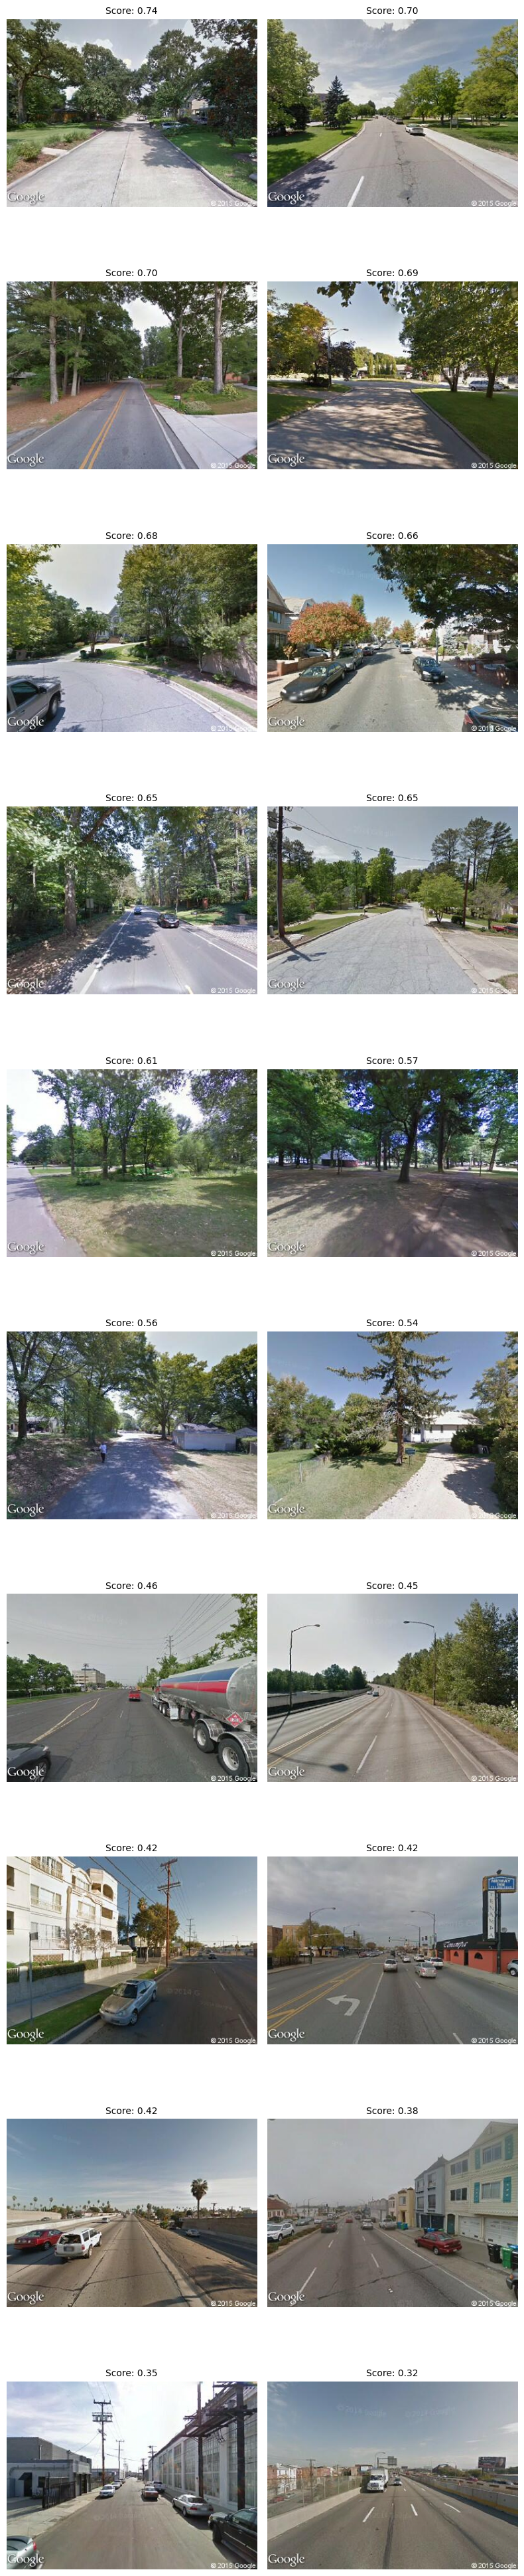

In [143]:
import matplotlib.pyplot as plt

all_imgs = os.listdir(image_dir)
id2path = {i.split("_")[2]:i for i in all_imgs}

img_preds = []
imgs = []

for img_id in img_ids:

    img_path = image_dir/f"{id2path[img_id]}"
    img = Image.open(img_path)
    imgs.append(img)

    inputs = processor(images=img, return_tensors="pt")["pixel_values"]

    with torch.inference_mode():
        pred = torch.sigmoid(model_infer(inputs))
        img_preds.append(pred.cpu().item())


def plot_predictions_sorted(images, predictions, cols=2, base_size=4):
    paired = sorted(zip(images, predictions), key=lambda x: x[1], reverse=True)

    n = len(paired)
    rows = (n + cols - 1) // cols
    figsize = (cols * base_size, rows * base_size)

    plt.figure(figsize=figsize)
    for i, (img, pred) in enumerate(paired):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        ax.set_title(f"Score: {pred:.2f}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.savefig("svi_scores.png")
    plt.show()



# Example:
plot_predictions_sorted(imgs, img_preds, cols=2, base_size=4)